<a href="https://colab.research.google.com/github/dimasprd/Tugas-Akhir/blob/main/Notebooks/001_WELL_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segypy
import segypy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, max_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras import layers

import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 200
# plt.style.use('seaborn')

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [2]:
dataset_F032 = pd.read_excel('/content/drive/My Drive/Final Project II/Datasets/F032.xlsx')
dataset_F034 = pd.read_excel('/content/drive/My Drive/Final Project II/Datasets/F034.xlsx')
dataset_F021 = pd.read_excel('/content/drive/My Drive/Final Project II/Datasets/F021.xlsx')
dataset_F061 = pd.read_excel('/content/drive/My Drive/Final Project II/Datasets/F061.xlsx')

In [3]:
print(
    'Well F032: ', dataset_F032[dataset_F032['TWT']==488].index[0],
    dataset_F032[dataset_F032['TWT']==1205.4].index[0]
)


print(
    'Well F034: ', dataset_F034[dataset_F034['TWT']==475.6].index[0],
    dataset_F034[dataset_F034['TWT']==1226].index[0]
)


print(
    'Well F021: ', dataset_F021[dataset_F021['TWT']==585.6].index[0],
    dataset_F021[dataset_F021['TWT']==1227.8].index[0]
)


print(
    'Well F061: ', dataset_F061[dataset_F061['TWT']==599.4].index[0],
    dataset_F061[dataset_F061['TWT']==1256.6].index[0]
)

Well F032:  2440 6027
Well F034:  2378 6130
Well F021:  2928 6139
Well F061:  2997 6283


In [4]:
data_F032 = dataset_F032[2440:6027]
data_F034 = dataset_F034[2378:6130]
data_F021 = dataset_F021[2928:6139]
data_F061 = dataset_F061[2997:6283]

In [5]:
def normalize(data, data_norm=None, normalize=True):
    '''
    to normalize data
    
    params:
    
    data: data to normalize. should in 2d array
    data_norm: data to unnormalize.
    normalize: (True, False). if True, 
    data will be normalize and "data_norm" param is unnecessary
    if False, "data_norm" is the data to be normalize 
    and "data" param is necessary
    '''
    min_val = min(data.values.flatten())
    max_val = max(data.values.flatten())
    
    if normalize:
        return (data - min_val)/(max_val - min_val)
    else:
        return data_norm*(max_val - min_val) + min_val

    
def scaling_col_values(data, min_val=None, max_val=None):
    '''
    function to normalize certain column values in DataFrame
    '''
    return (data - min_val)/(max_val - min_val)


def scaling_df_values(df):
    '''
    function to normalize all columns values in DataFrame
    '''
    df_scaled = df.copy()
    for i in range(len(df_scaled.columns)):
        min_val = min(df_scaled[df_scaled.columns[i]])
        max_val = max(df_scaled[df_scaled.columns[i]])
        df_scaled[df_scaled.columns[i]] = scaling_col_values(
            df_scaled[df_scaled.columns[i]], 
            min_val=min_val, max_val=max_val
        )
    return df_scaled


def absolute_error(actual_data, prediction_data):
    '''
    function to calculate absolute error
    '''
    return abs(actual_data - prediction_data)


def load_data(data):
    '''
    function to load seismic data
    '''
    read = segypy.readSegy(data)
    return read[0]

def filter(data, order=5, cutoff=10, fs=1000/2):
    df = pd.DataFrame(data).apply(
        lambda data: filtfilt(
            butter(order, (cutoff / (0.5 * fs)), 
                   btype='low', analog=False)[0], 
            butter(order, (cutoff / (0.5 * fs)), 
                   btype='low', analog=False)[1],
            data
        )
    )
    return df

In [6]:
features = ['LFM_PW', 'SEISMIC', 'QUAD', 'AMP_ENV']
target = ['TRUE_AI']

In [7]:
training_wells = [data_F021, data_F034, data_F032]
testing_wells = [data_F061]

training_wells_comp = pd.concat(training_wells)
training_wells_comp = training_wells_comp.sample(frac=1)

testing_well_comp = testing_wells[0]

X_train = training_wells_comp[features]
y_train = training_wells_comp[target]

X_test = testing_well_comp[features]
y_test = testing_well_comp[target]

In [8]:
from sklearn import preprocessing

scaler_x = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler_x.fit(X_train)
X_train_scaled = scaler_x.transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(y_train)
y_train_scaled = scaler_y.transform(y_train) 
y_test_scaled = scaler_y.transform(y_test)

In [9]:
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns = X_train.columns
)

y_train_scaled = pd.DataFrame(
    y_train_scaled,
    columns = y_train.columns
)


X_test_scaled = pd.DataFrame(
    X_test_scaled,
    columns = X_test.columns
)

y_test_scaled = pd.DataFrame(
    y_test_scaled,
    columns = y_test.columns
)

# Convolutional Neural Network (CNN)

In [ ]:
# Input shape: (nb_of_examples, timesteps, features).
X_train_scaled_cnn = np.array(X_train_scaled).reshape(
    X_train_scaled.shape[0], X_train_scaled.shape[1], 1
)
X_test_scaled_cnn = np.array(X_test_scaled).reshape(
    X_test_scaled.shape[0], X_test_scaled.shape[1], 1
)

y_train_scaled_cnn = np.array(y_train_scaled).reshape(-1, 1, 1)
y_test_scaled_cnn = np.array(y_test_scaled).reshape(-1, 1, 1)

batch_size = 32
num_classes = 1
epochs = 800

input_shape=(X_train_scaled_cnn.shape[1], 1)

In [ ]:
model_cnn = Sequential()
input_shape=(X_train_scaled_cnn.shape[1], 1)

model_cnn.add(
    (
        Conv1D(
            256, kernel_size=2, padding = 'same',
            activation='relu', input_shape=input_shape
        )
    )
)

model_cnn.add(
    (MaxPooling1D(pool_size=2, padding='same'))

)
model_cnn.add(
    Conv1D(
        256, kernel_size=2, padding = 'same',
        activation='relu', input_shape=input_shape
    )
) 

model_cnn.add(Dropout(0.2))
model_cnn.add(
    Conv1D(256, kernel_size=2,padding = 'same',activation='relu')
)
model_cnn.add(
    keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D")
)
model_cnn.add(keras.layers.Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(64, activation='relu'))

model_cnn.add(Dense(num_classes, activation='linear'))
model_cnn.compile(loss="mse", optimizer="adam")
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 256)            768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 256)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 256)            131328    
                                                                 
 dropout_9 (Dropout)         (None, 2, 256)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 256)            131328    
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 1, 256)           0         
                                                        

In [ ]:
history_cnn = model_cnn.fit(
    X_train_scaled_cnn, y_train_scaled_cnn, 
    epochs=epochs, batch_size=batch_size, validation_split = 0.2
)
model_cnn.evaluate(X_test_scaled_cnn, y_test_scaled_cnn)

Epoch 1/800
264/264 [==============================] - 14s 7ms/step - loss: 0.0151 - val_loss: 0.0062
Epoch 2/800
264/264 [==============================] - 1s 5ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 3/800
264/264 [==============================] - 2s 6ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 4/800
264/264 [==============================] - 1s 5ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 5/800
264/264 [==============================] - 1s 5ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 6/800
264/264 [==============================] - 1s 5ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 7/800
264/264 [==============================] - 1s 5ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 8/800
264/264 [==============================] - 1s 5ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 9/800
264/264 [==============================] - 1s 5ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 10/800
264/264 [==============================] - 2s 6ms/step - loss: 0.0051 - val_l

0.006144624203443527

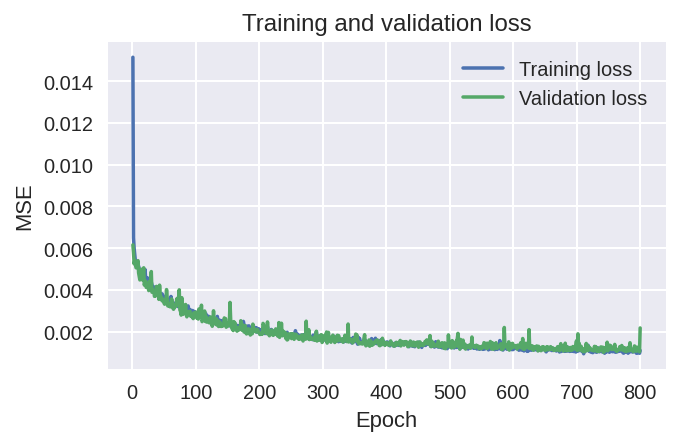

In [ ]:
plt.rcParams['figure.dpi'] = 144
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5, 3))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predicting
pred_cnn_scaled = model_cnn.predict(X_test_scaled_cnn)

# Inverse transform
temp1 = pred_cnn_scaled.reshape((pred_cnn_scaled.shape[0], 1))
pred_cnn = scaler_y.inverse_transform(temp1)
pred_cnn = np.array(pred_cnn)

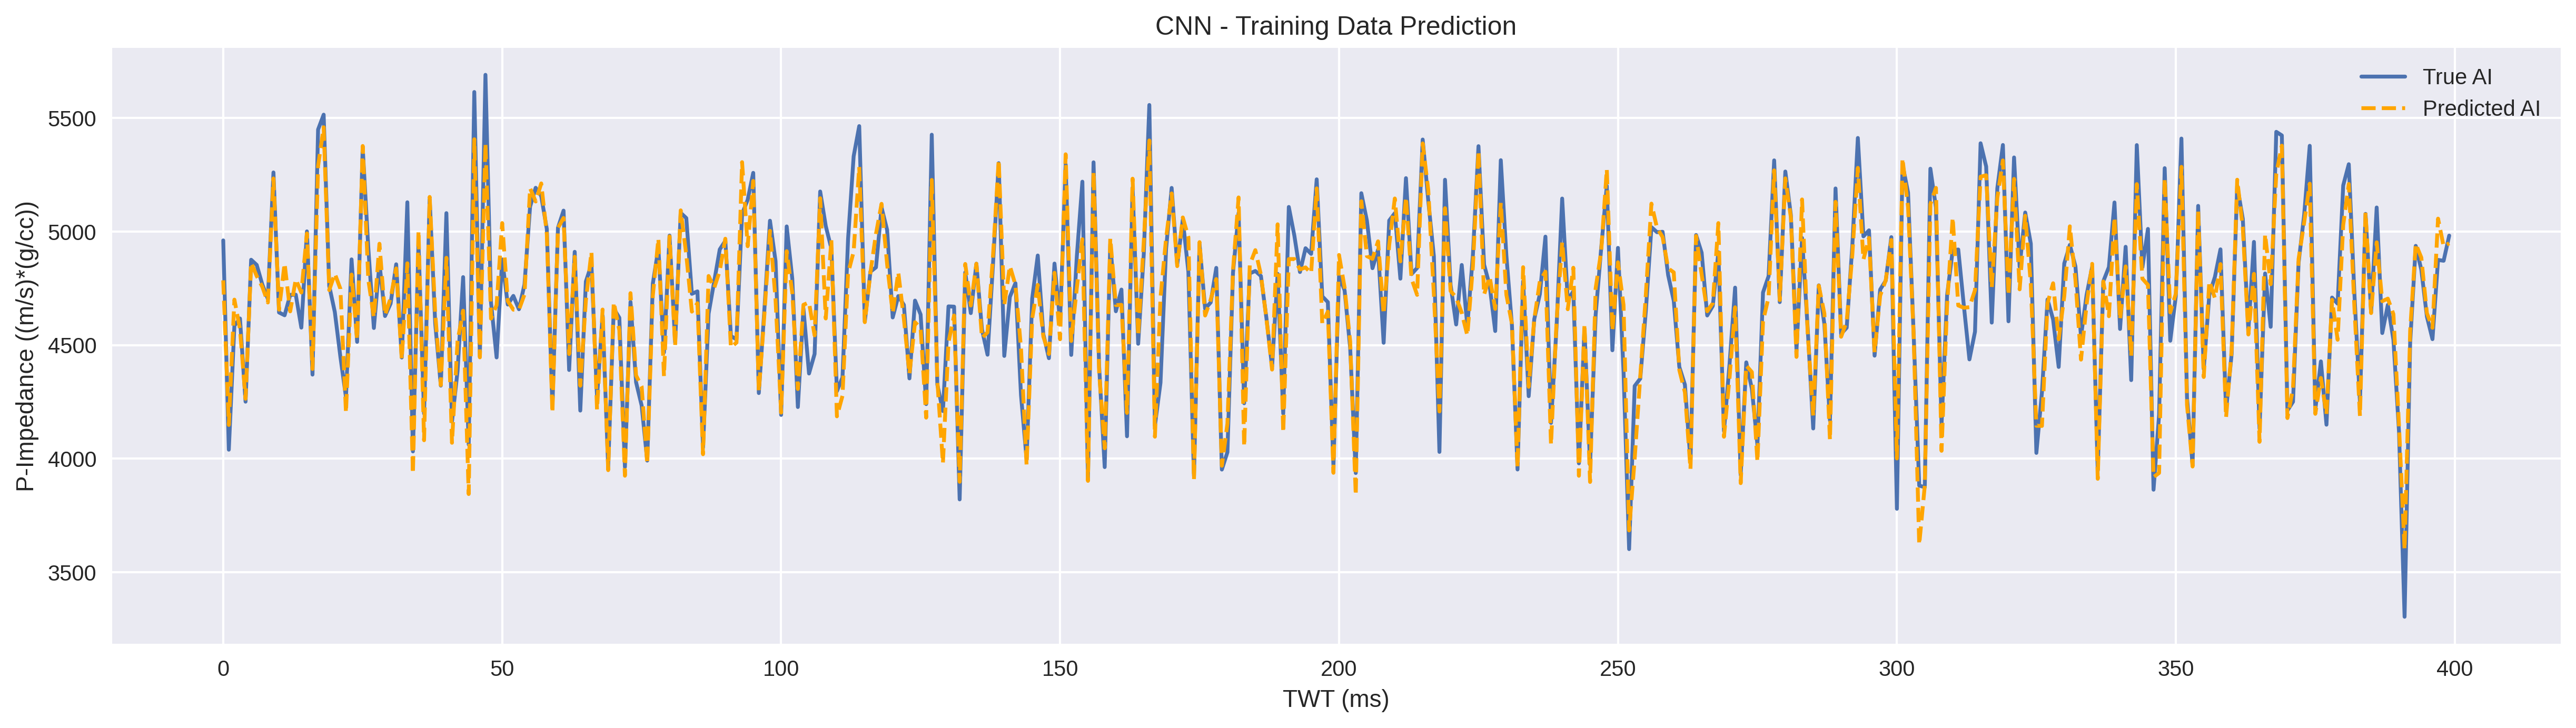

In [ ]:
# Training data
plt.rcParams['figure.dpi'] = 300
pred_train_cnn_scaled = model_cnn.predict(X_train_scaled_cnn)
temp1 = pred_train_cnn_scaled.reshape((pred_train_cnn_scaled.shape[0], 1))
pred_train_cnn = scaler_y.inverse_transform(temp1)
pred_train_cnn = np.array(pred_train_cnn)


plt.figure(figsize = (20,5))
plt.plot(y_train[100:500].values, label = "True AI")
plt.plot(pred_train_cnn[100:500], "--", color = "orange", label = "Predicted AI")


plt.title('CNN - Training Data Prediction')
plt.xlabel("TWT (ms)")
plt.ylabel("P-Impedance $((m/s)*(g/cc))$")
plt.legend()
plt.show()

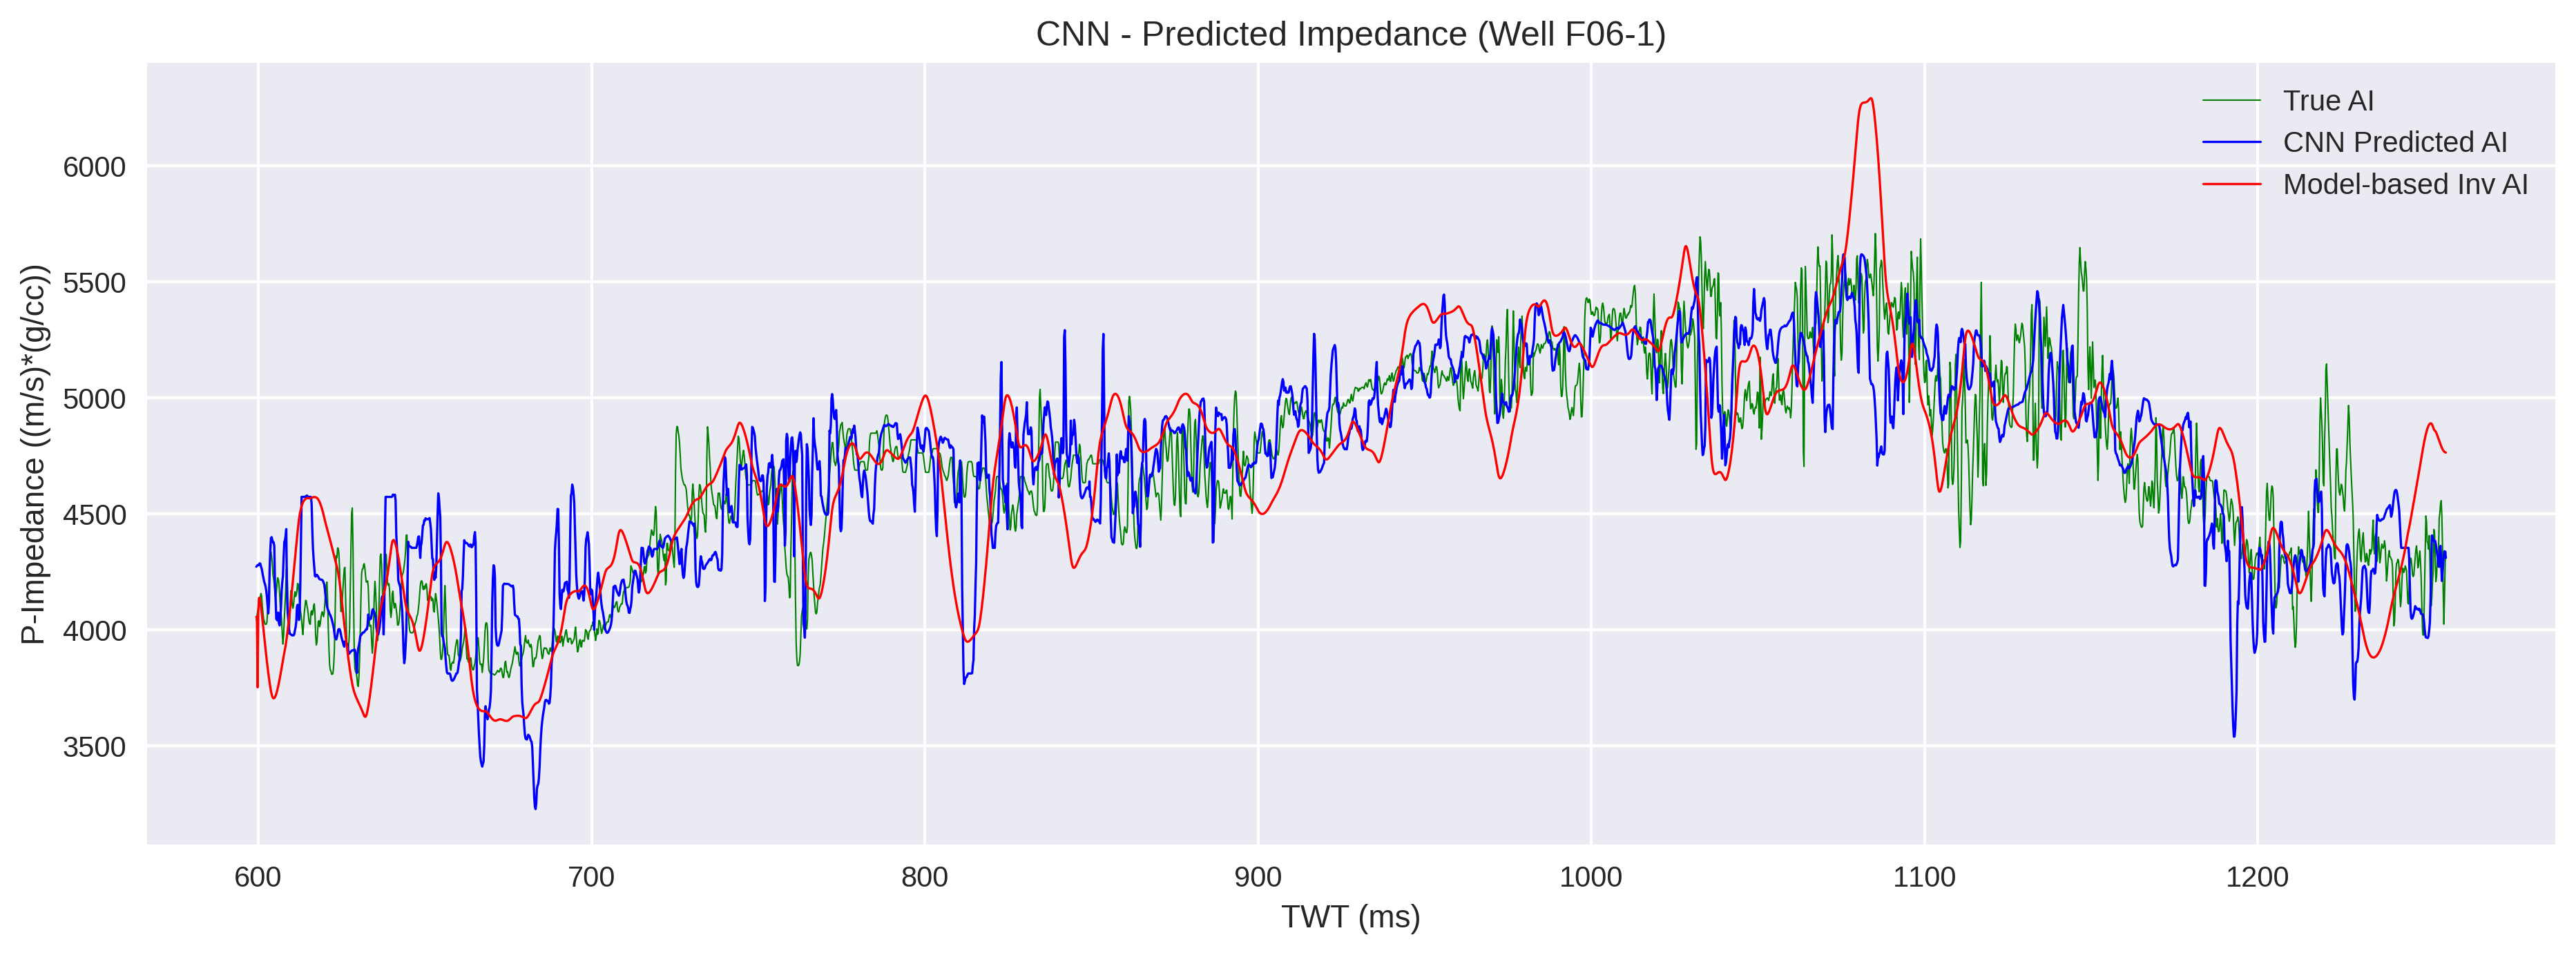

In [ ]:
# Testing data
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize = (15,5))
plt.plot(data_F021['TWT'], y_test, color='k', label = "True AI")
plt.plot(data_F021['TWT'], pred_cnn, "-", color = "r", label = "CNN Predicted AI")
plt.plot(data_F021['TWT'], data_F021['MBI'], color='blue', linewidth=0.8, label = "Model-based Inv AI")

plt.title('CNN - Predicted Impedance (Well F06-1)')
plt.xlabel("TWT (ms)")
plt.ylabel("P-Impedance $((m/s)*(g/cc))$")
plt.legend()
plt.show()

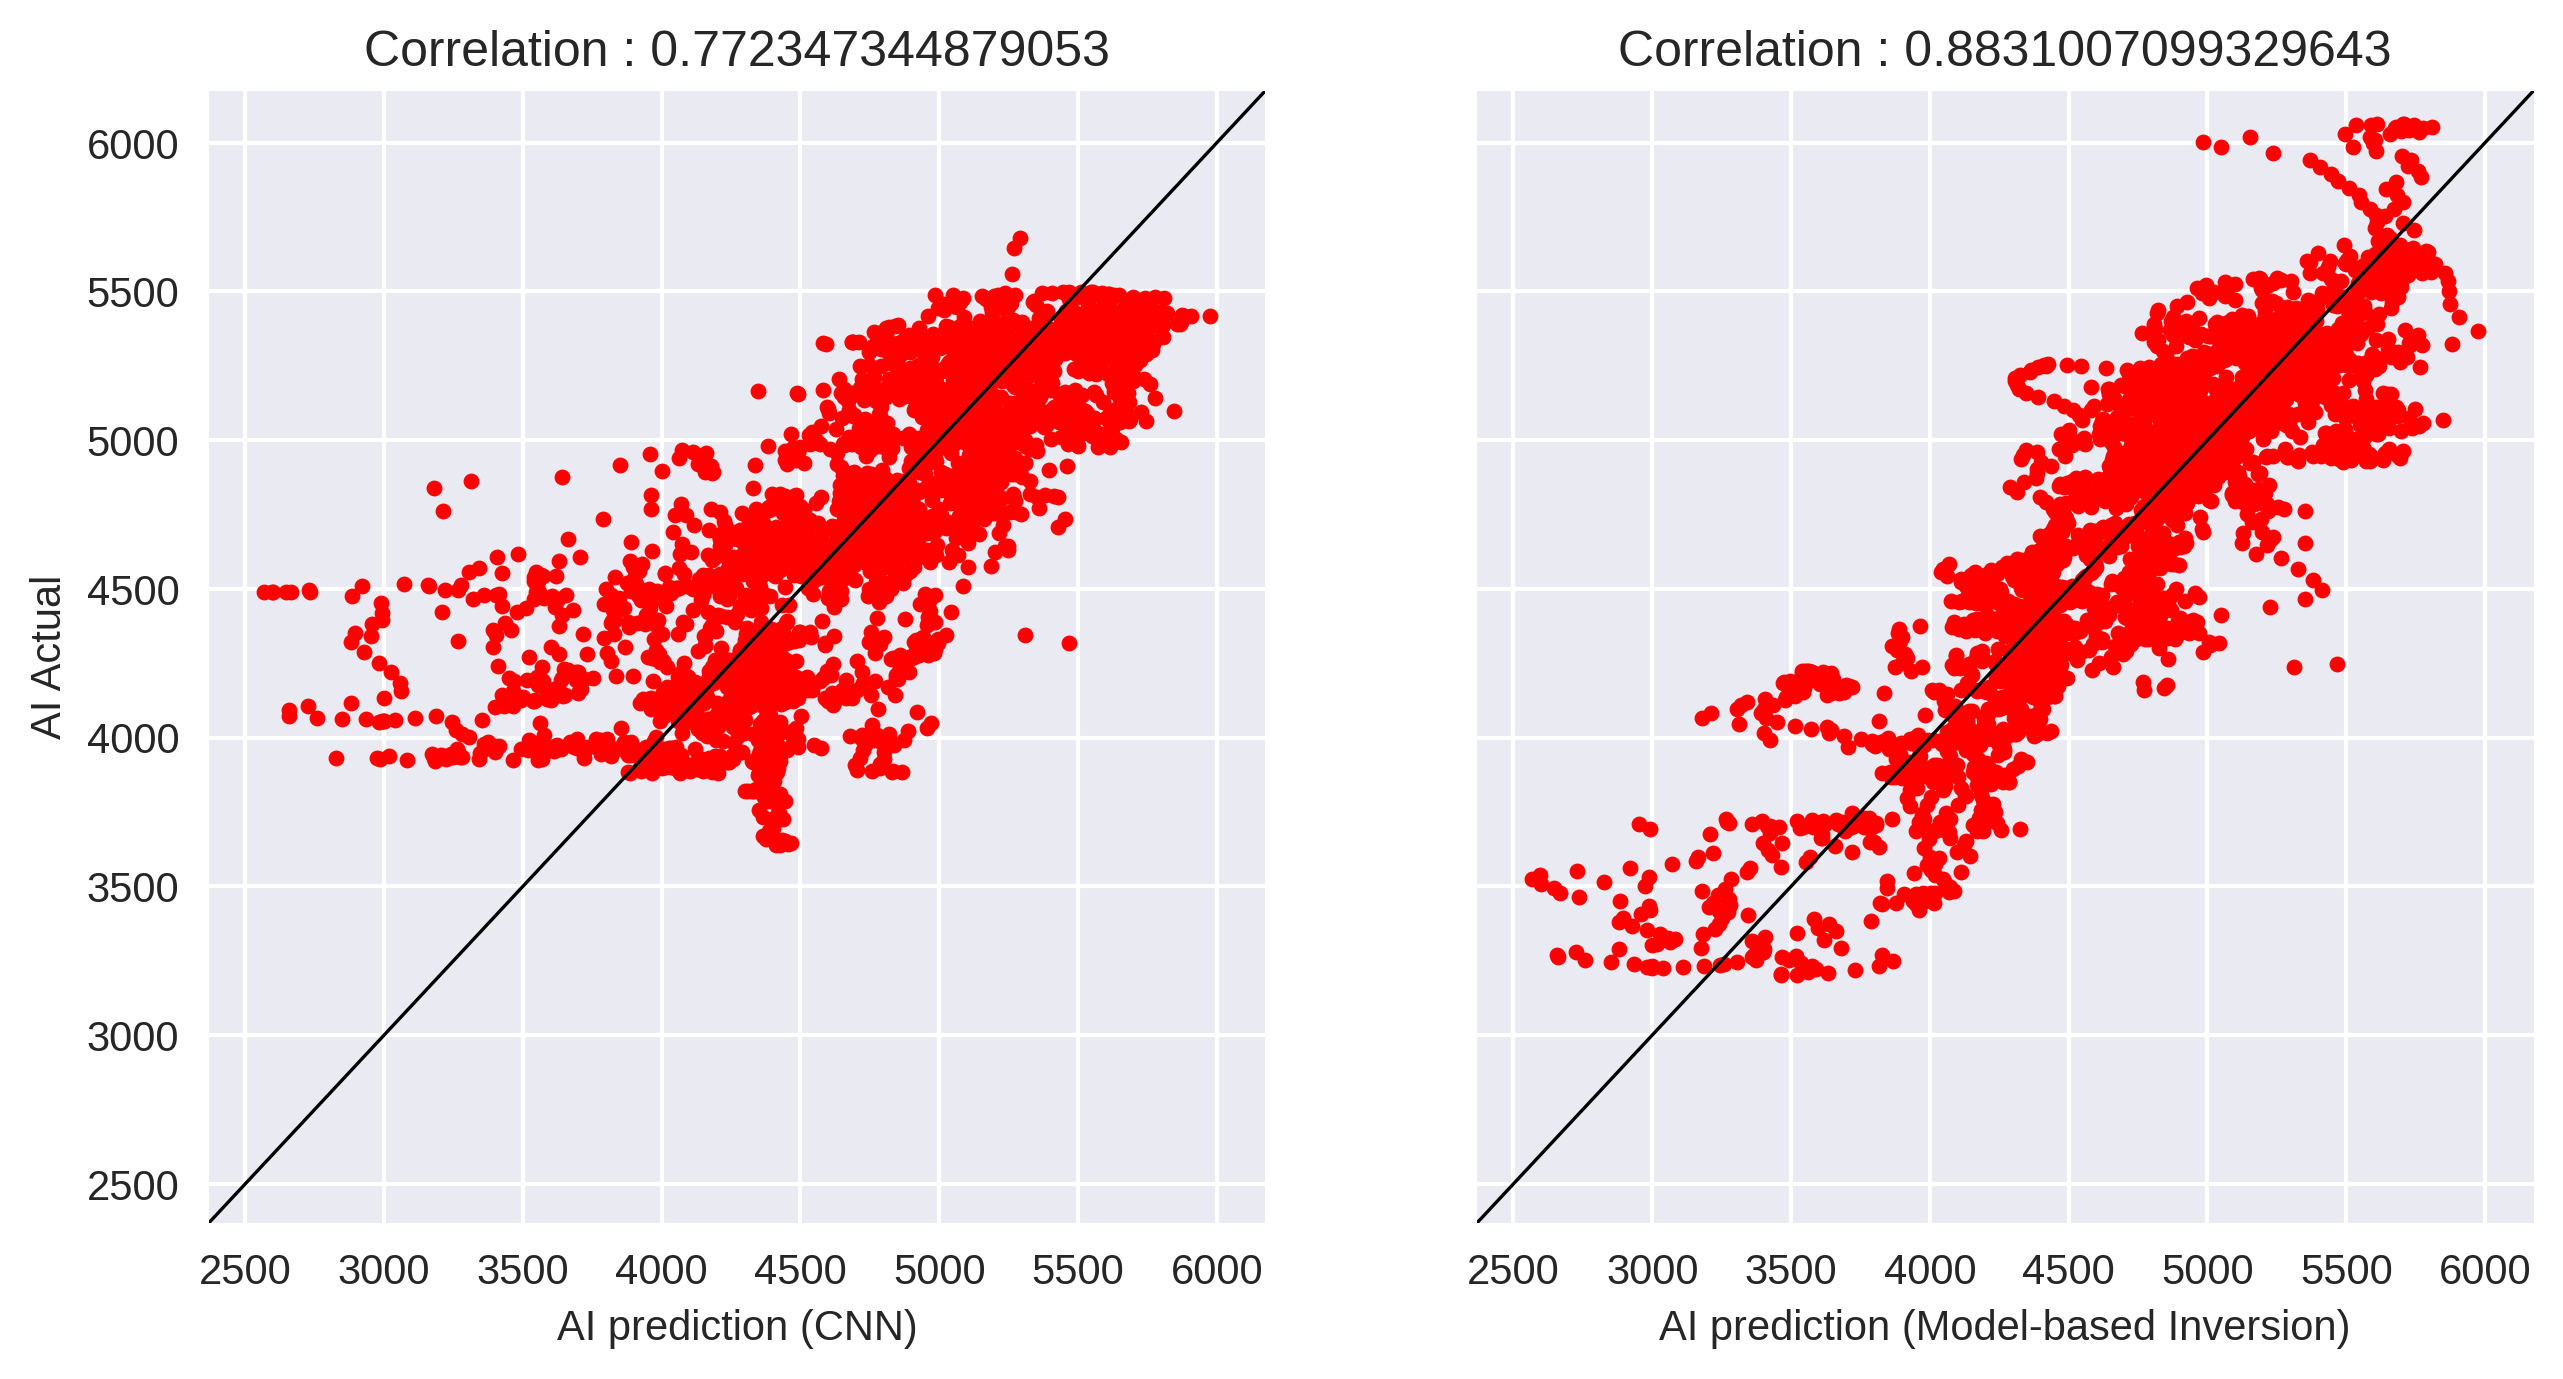

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

correlation1 = np.corrcoef(y_test.values.flatten(), pred_cnn.flatten())[0:1][0][1]
correlation2 = np.corrcoef(y_test.values.flatten(), data_F021['MBI'].values)[0:1][0][1]
lim = [min(y_test.values.flatten()) - 200, max(y_test.values.flatten()) + 200]

fontsize=10

ax[0].scatter(y_test, pred_cnn, color='r', marker='.')
ax[0].plot((np.arange(lim[0], lim[1])), (np.arange(lim[0], lim[1])), color='k', linewidth=0.8)
ax[0].set_title(f"Correlation : {correlation1}")
ax[0].set_ylabel("True P-Impedance", fontsize=fontsize)
ax[0].set_xlabel("Predicted P-Impedance (CNN)", fontsize=fontsize)
ax[0].set_xlim(lim[0], lim[1])
ax[0].set_ylim(lim[0], lim[1])

ax[1].scatter(y_test, data_F021['MBI'], color='r', marker='.')
ax[1].plot((np.arange(lim[0], lim[1])), (np.arange(lim[0], lim[1])), color='k', linewidth=0.8)
ax[1].set_title(f"Correlation : {correlation2}")
# ax[1].set_ylabel("AI Actual", fontsize=fontsize)
ax[1].set_xlabel("Predicted P-Impedance (Model-based Inversion)", fontsize=fontsize)
ax[1].set_xlim(lim[0], lim[1])
ax[1].set_ylim(lim[0], lim[1])
# plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

# LSTM

In [ ]:
X_train_scaled_lstm = np.array(X_train_scaled).reshape(-1, 1, len(features))
X_test_scaled_lstm  = np.array(X_test_scaled).reshape(-1, 1, len(features))

y_train_scaled_lstm = np.array(y_train_scaled).reshape(-1, 1, 1)
y_test_scaled_lstm = np.array(y_test_scaled).reshape(-1, 1, 1)

X_test_scaled_lstm.shape, y_test_scaled_lstm.shape

In [ ]:
# Early stopping patience
# callbacks = [k.callbacks.EarlyStopping(patience = 3)]

# LSTM
model_lstm = Sequential([
                     LSTM(512, input_shape=(1,len(features)), # input shape: (time step, features)
                          recurrent_dropout = 0.15, # is a regularization method for recurrent neural networks. 
                          return_sequences = True), # refer to return the hidden state
                     Dropout(0.2),
                     layers.Dense(1, activation='linear')
])


model_lstm.compile(loss="mse", optimizer="adam")


# history_lstm = model_lstm.fit(X_train_scaled_lstm, y_train_scaled_lstm, epochs=100,
#                     validation_split = 0.2, callbacks=callbacks)

history_lstm = model_lstm.fit(X_train_scaled_lstm, y_train_scaled_lstm, epochs=800,
                    validation_split = 0.2)

model_lstm.evaluate(X_test_scaled_lstm, y_test_scaled_lstm)

In [ ]:
plt.rcParams['figure.dpi'] = 144
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5, 3))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predicting
pred_lstm_scaled = model_lstm.predict(X_test_scaled_lstm)

# Inverse transform
temp1 = pred_lstm_scaled.reshape((pred_lstm_scaled.shape[0], 1))
pred_lstm = scaler_y.inverse_transform(temp1)
pred_lstm = np.array(pred_lstm)

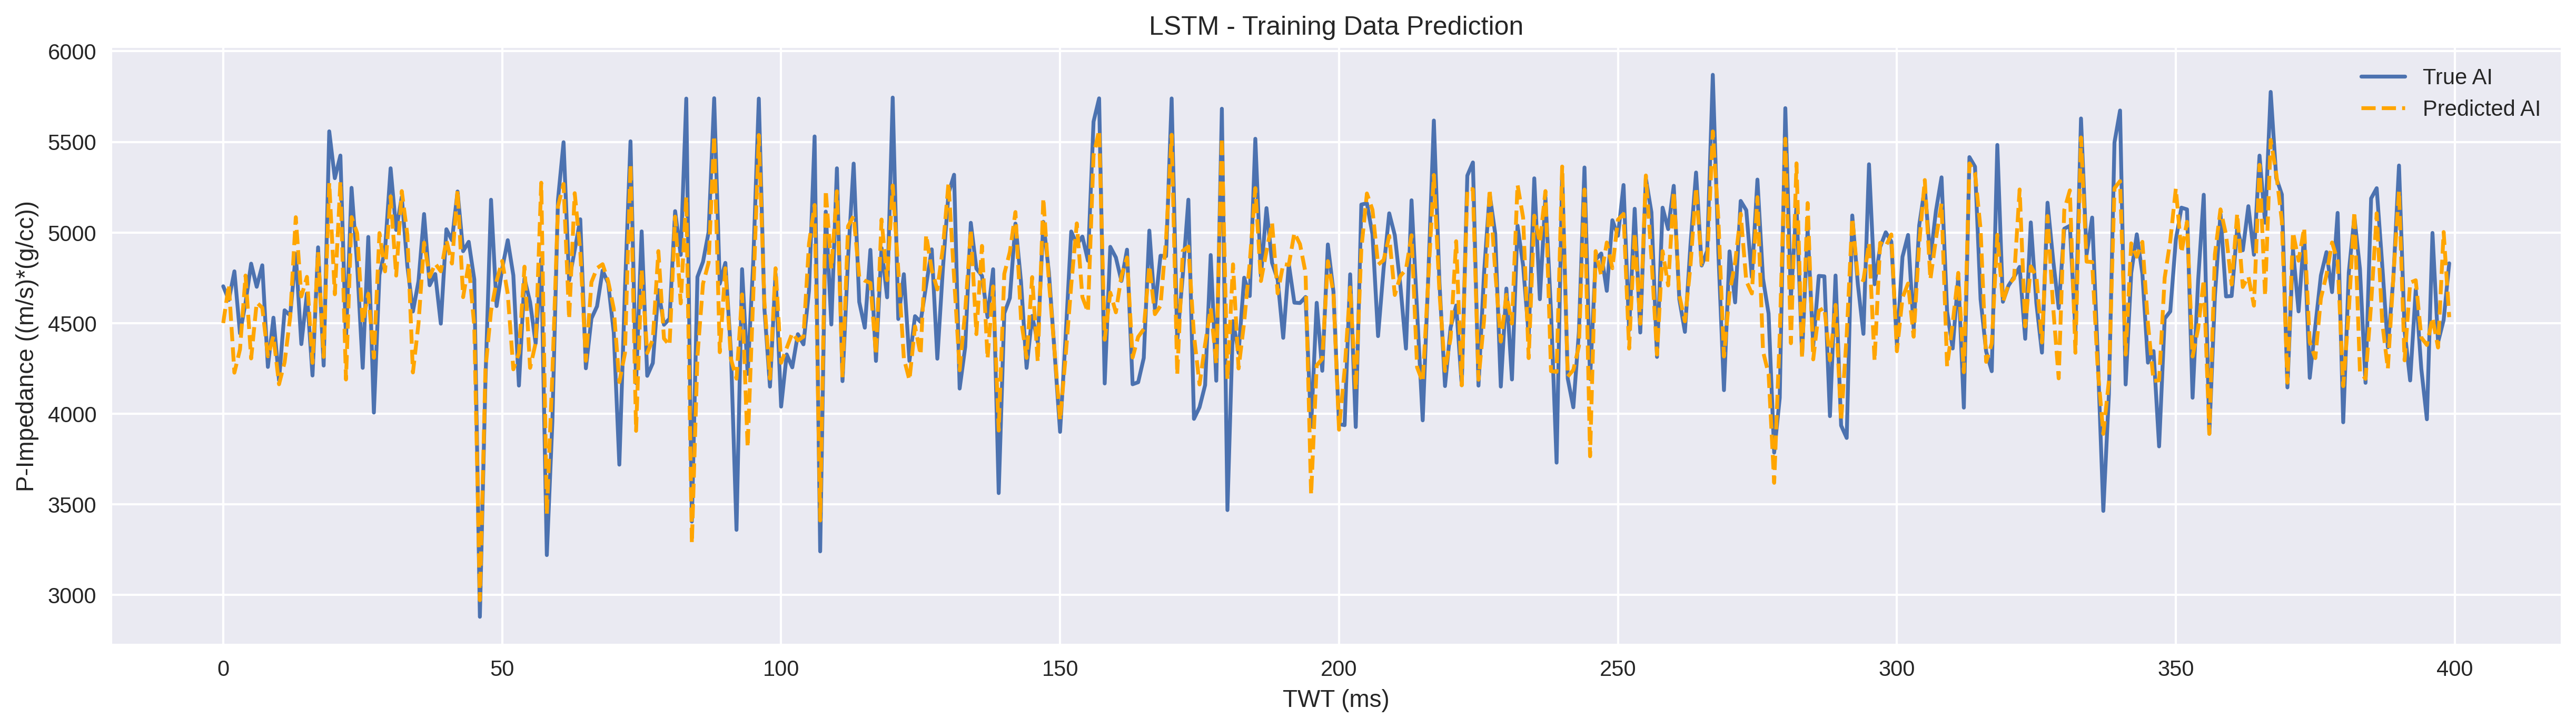

In [ ]:
# Training data
plt.rcParams['figure.dpi'] = 300
pred_train_lstm_scaled = model_lstm.predict(X_train_scaled_lstm)
temp1 = pred_train_lstm_scaled.reshape((pred_train_lstm_scaled.shape[0], 1))
pred_train_lstm = scaler_y.inverse_transform(temp1)
pred_train_lstm = np.array(pred_train_lstm)


plt.figure(figsize = (20,5))
plt.plot(y_train[100:500].values, label = "True AI")
plt.plot(pred_train_lstm[100:500], "--", color = "orange", label = "Predicted AI")


plt.title('LSTM - Training Data Prediction')
plt.xlabel("TWT (ms)")
plt.ylabel("P-Impedance ((m/s)*(g/cc))")
plt.legend()
plt.show()

# CNN + LSTM

In [ ]:
# Input shape: (nb_of_examples, timesteps, features).
X_train_scaled_clstm = np.array(X_train_scaled).reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled_clstm = np.array(X_test_scaled).reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

y_train_scaled_clstm = np.array(y_train_scaled).reshape(-1, 1, 1)
y_test_scaled_clstm = np.array(y_test_scaled).reshape(-1, 1, 1)

batch_size = 32
num_classes = 1
epochs = 300
input_shape=(X_train_scaled_clstm.shape[1], 1)

In [ ]:
model_clstm = Sequential()
input_shape=(X_train_scaled_clstm.shape[1], 1)
# Feature engineering
# Cross-correlation with features -> extract main information from features
# -> A stabilizing factor
model_clstm.add((Conv1D(256, kernel_size=5,padding = 'same',activation='relu', input_shape=input_shape)))
model_clstm.add((MaxPooling1D(pool_size=2,padding='same'))) # combining features
model_clstm.add(Conv1D(256, kernel_size=4,padding = 'same',activation='relu', input_shape=input_shape)) # added stride
model_clstm.add(Dropout(0.2))
model_clstm.add(Conv1D(256, kernel_size=3,padding = 'same',activation='relu'))
model_clstm.add(Dropout(0.2))
# Define LSTM model
model_clstm.add(LSTM(128, recurrent_dropout = 0.2))
# Output layer
model_clstm.add(Dense(num_classes, activation='linear'))
model_clstm.compile(loss="mse", optimizer="adam")
model_clstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 256)            1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 256)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 256)            262400    
                                                                 
 dropout (Dropout)           (None, 2, 256)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 256)            196864    
                                                                 
 dropout_1 (Dropout)         (None, 2, 256)            0         
                                                        

In [ ]:
history_clstm = model_clstm.fit(X_train_scaled_clstm, y_train_scaled_clstm, epochs=epochs,
                                batch_size=batch_size, validation_split = 0.2)
model_clstm.evaluate(X_test_scaled_clstm, y_test_scaled_clstm)

Epoch 1/300
264/264 [==============================] - 18s 54ms/step - loss: 0.0144 - val_loss: 0.0064
Epoch 2/300
264/264 [==============================] - 21s 78ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 3/300
264/264 [==============================] - 13s 51ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 4/300
264/264 [==============================] - 13s 50ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 5/300
264/264 [==============================] - 14s 54ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 6/300
264/264 [==============================] - 13s 50ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 7/300
264/264 [==============================] - 13s 50ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 8/300
264/264 [==============================] - 13s 50ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 9/300
264/264 [==============================] - 15s 58ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 10/300
264/264 [==============================] - 13s 49ms/step - l

In [ ]:
plt.rcParams['figure.dpi'] = 144
loss = history_clstm.history['loss']
val_loss = history_clstm.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5, 3))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and validation loss')
plt.legend()

plt.show()